# 1. 클래스 별 폴더 만들기

모든 클래스가 하나의 폴더에 들어있고, **labels.csv**에 각 파일의 클래스 정보가 있다. 따라서 이를 이용하여 클래스 별 폴더로 나누겠다. 

## 1.1. pandas를 사용하여 csv파일 읽기

In [1]:
import pandas as pd
labels = pd.read_csv("./labels.csv")

## 1.2. 각 클래스 별 폴더 만들기

dataset 폴더를 만들고, 하위 폴더에 각 클래스를 저장하겠다.

In [2]:
import os

os.makedirs("./dataset", exist_ok=True)

for class_name in labels['breed'].unique():
    os.makedirs("./dataset/"+class_name, exist_ok=True)  # exist_ok가 True이면 디렉토리가 이미 있는 경우는 넘어가고, 없으면 만든다.

## 1.3. 모든 이미지 파일은 jpg 임을 확인

In [3]:
for file_name in os.listdir("./train"):
    if file_name.split('.')[-1] != 'jpg':
        print(file_name)

## 1.4. labels.csv에 기반하여 파일을 폴더 별로 분류

In [4]:
import shutil

for idx, row in labels.iterrows():
    file_name = row['id']
    class_name = row['breed']
    shutil.copy("./train/"+file_name+".jpg", "./dataset/"+class_name+'/'+file_name+".jpg")

## 1.5. 데이터 크리에이터 캠프에서 만든 draw_class_barplot 함수로 클래스 별 데이터 수 확인

전체 데이터 수: 10222


<Figure size 10000x10000 with 0 Axes>

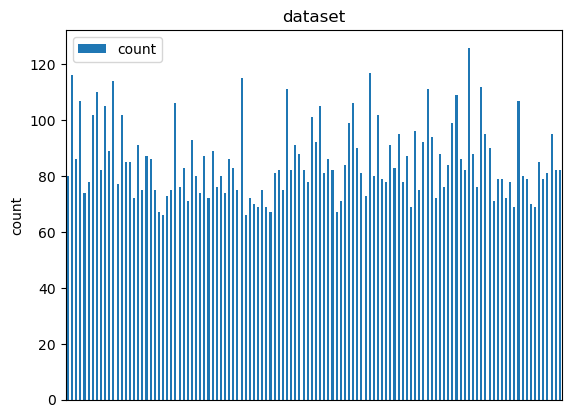

In [5]:
import matplotlib.pyplot as plt

def draw_class_barplot(
    path: str,
    title: str):
    
    dir_list = os.listdir(path)

    classLenLst = []
    for class_name in dir_list:
        classLenLst.append(len(os.listdir(path+class_name)))
        
    df_dict = dict()
    df_dict["name"] = dir_list
    df_dict["count"] = classLenLst

    df= pd.DataFrame(df_dict)

    plt.figure(figsize=(100,100))
    df.plot(kind="bar", x='name', y='count')
    plt.xlabel("class name")
    plt.ylabel("count")
    plt.title(title)
    ax = plt.gca()

    #hide x-axis
    ax.get_xaxis().set_visible(False)

    return df

df = draw_class_barplot("./dataset/", "dataset")
print(f"전체 데이터 수: {df['count'].sum(0)}")

# 2. train, test 데이터 나누기

## 2.1. train_dataset, test_dataset 폴더 만들기

In [6]:
os.makedirs("./train_dataset", exist_ok=True)
os.makedirs("./test_dataset", exist_ok=True)

for class_name in labels['breed'].unique():
    os.makedirs("./train_dataset/"+class_name, exist_ok=True)  # exist_ok가 True이면 디렉토리가 이미 있는 경우는 넘어가고, 없으면 만든다.
    os.makedirs("./test_dataset/"+class_name, exist_ok=True)

## 2.2. 데이터의 80%를 학습 20%를 test로 사용

각 클래스 별로 20%의 데이터를 test 데이터로 사용

In [7]:
TRAIN_PCT = 0.8

In [8]:
class_lst = os.listdir("./dataset")

for label_name in class_lst:
    file_lst = os.listdir("./dataset/"+label_name)
    for file_name in file_lst[:round(len(file_lst)*TRAIN_PCT)]:
        shutil.copy("./dataset/"+label_name+'/'+file_name, "./train_dataset/"+label_name+'/'+file_name)
        
    for file_name in file_lst[round(len(file_lst)*TRAIN_PCT):]:
        shutil.copy("./dataset/"+label_name+'/'+file_name, "./test_dataset/"+label_name+'/'+file_name)

## 2.3. 나눠진 데이터를 확인

전체 train 데이터 수: 8185
전체 test 데이터 수: 2037


<Figure size 10000x10000 with 0 Axes>

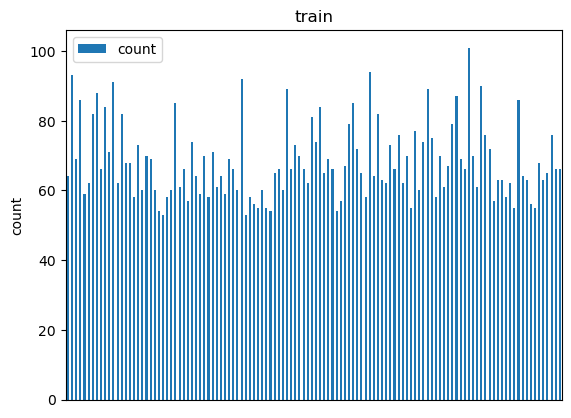

<Figure size 10000x10000 with 0 Axes>

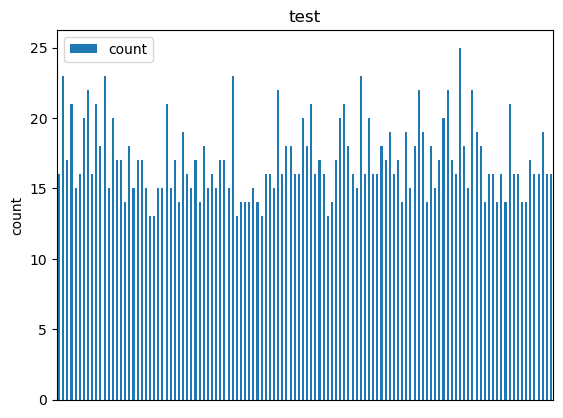

In [9]:
df = draw_class_barplot("./train_dataset/", "train")
print(f"전체 train 데이터 수: {df['count'].sum(0)}")
df = draw_class_barplot("./test_dataset/", "test")
print(f"전체 test 데이터 수: {df['count'].sum(0)}")

# 3. PyTorch 학습 코드 작성

## <span style="color:blue">*. **PyTorch Ignite 모듈 불러오기**</span>.

In [1]:
from ignite.engine import Engine, Events
from ignite.metrics import RunningAverage
from ignite.contrib.handlers.tqdm_logger import ProgressBar

D:\programs\Anaconda\envs\RL_module\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## <span style="color:blue">*. **Ignite Engine 클래스 만들기**</span>.

In [2]:
class MyEngine(Engine):
    
    def __init__(
        self,
        func,  # Engine Class가 필요로 하는 파라미터
        model,
        criterion,
        optimizer,
        batch_size: int,
        num_workers: int):
        
        super().__init__(func)
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        self.device = next(self.model.parameters()).device

## 3.1. 이미지 전처리 리스트 작성

torchvision의 transoform을 사용하여 전처리 리스트를 작성한다.

In [3]:
import torchvision.transforms as transforms

RESIZE = 224

transformer = transforms.Compose([
    transforms.Resize(RESIZE),
    transforms.CenterCrop(RESIZE),
    transforms.ToTensor(),  # ToTensor는 0 ~ 255로 이루어진 정수를 0 ~ 1의 실수로 바꿔준다.
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

## 3.2. ImageFolder 메소드를 사용하여 dataloader 생성

In [4]:
# 파라미터 설정
BATCH_SIZE = 64
NUM_WORKERS = 0  # 이 값은 사용하는 쓰레드를 의미하므로 적절히 설정하자 (0는 main thread 사용을 의미한다)

In [5]:
import torch
import torchvision

train_dataset = torchvision.datasets.ImageFolder(
    root="./train_dataset",
    transform=transformer)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

## 3.3. 모델 만들기

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# Pretrained model 불러오기
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)  # Pretrained resnet18 불러오기

# Freeze All Layers
for p in model.parameters():
    p.requires_grad = False

num_features = model.fc.in_features  # Convolutional Layer로 얻어지는 feature 가져오기
model.fc = nn.Linear(num_features, 120)  # 120개의 클래스를 구분할 수 있도록 마지막 fully connected layer 수정하기

model.to(device)

'''
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(self.fc_input_size(), 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 120)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    @staticmethod
    def fc_input_size():
        return int(16*((((RESIZE-4)/2)-4)/2)**2)
    
model = Model().to(device)
'''

'\ndevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\n\nclass Model(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.conv1 = nn.Conv2d(3, 6, 5)\n        self.pool = nn.MaxPool2d(2, 2)\n        self.conv2 = nn.Conv2d(6, 16, 5)\n        self.fc1 = nn.Linear(self.fc_input_size(), 120)\n        self.fc2 = nn.Linear(120, 84)\n        self.fc3 = nn.Linear(84, 120)\n        \n    def forward(self, x):\n        x = self.pool(F.relu(self.conv1(x)))\n        x = self.pool(F.relu(self.conv2(x)))\n        x = torch.flatten(x, 1)  # flatten all dimensions except batch\n        x = F.relu(self.fc1(x))\n        x = F.relu(self.fc2(x))\n        x = self.fc3(x)\n        return x\n    \n    @staticmethod\n    def fc_input_size():\n        return int(16*((((RESIZE-4)/2)-4)/2)**2)\n    \nmodel = Model().to(device)\n'

## 3.4. loss function, optimizer 정의

In [7]:
from torch import optim

learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## 3.5. 테스트 함수 작성

In [8]:
# test_dataloader를 정의
test_dataset = torchvision.datasets.ImageFolder(
    root="./test_dataset",
    transform=transformer)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

# 테스트 함수
def test(engine, mini_batch):
    engine.model.eval()  # model을 evaluation 하기 위한 상태로 바꾼다.
    
    inputs, labels = mini_batch
    inputs, labels = inputs.to(engine.device), labels.to(engine.device)

    outputs = engine.model(inputs)
    outputs = F.softmax(outputs, dim=0)  # 확률 값으로 변경

    loss = engine.criterion(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)

    total = labels.size(0)
    correct = (predicted == labels).sum().item()

    test_loss = loss.item()
    accuracy = correct / total
    
    return {
        'loss': float(test_loss),  # 강의에서 배운 gradient graph를 끊는 과정
        'accuracy': float(accuracy)
    }

## <span style="color:blue">3.5. 학습 함수 작성</span>

In [9]:
def train(engine, mini_batch):
    engine.model.train()  # 모델을 학습하기 위한 상태로 변경
    
    engine.optimizer.zero_grad()

    inputs, labels = mini_batch
    inputs, labels = inputs.to(engine.device), labels.to(engine.device)

    outputs = engine.model(inputs)
    outputs = F.softmax(outputs, dim=0)  # 확률 값으로 변경
    loss = engine.criterion(outputs, labels)
    loss.backward()
    engine.optimizer.step()

    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()

    train_loss = loss.item()
    accuracy = correct / total
    
    return {
        'loss': float(train_loss),
        'accuracy': float(accuracy)
    }

## <span style="color:blue">*. 학습, 테스트 엔진 작성</span>

In [10]:
train_engine = MyEngine(
    train,
    model,
    criterion,
    optimizer,
    BATCH_SIZE,
    NUM_WORKERS
    )

test_engine = MyEngine(
    test,
    model,
    criterion,
    optimizer,
    BATCH_SIZE,
    NUM_WORKERS
    )

## <span style="color:blue">*. 이벤트 작성</span>

In [11]:
# Train
RunningAverage(output_transform=lambda x: x['loss']).attach(
    train_engine,
    "loss"
)
RunningAverage(output_transform=lambda x: x['accuracy']).attach(
    train_engine,
    "accuracy"
)

# Test
RunningAverage(output_transform=lambda x: x['loss']).attach(
    test_engine,
    "loss"
)
RunningAverage(output_transform=lambda x: x['accuracy']).attach(
    test_engine,
    "accuracy"
)

@test_engine.on(Events.EPOCH_COMPLETED)
def print_test_logs(engine):
    print("Test Loss: {:.4e}\nAccuracy: {:.4f}".format(
        engine.state.metrics['loss'],
        engine.state.metrics['accuracy']))

# Or the other way is
'''
def print_test_logs(engine):
    print("Test Loss: {:.4e}\nAccuracy: {:.4f}".format(
        engine.state.metrics['loss'],
        engine.state.metrics['accuracy']))

test_engine.add_event_handler(
    Events.EPOCH_COMPLETED,
    print_test_logs,
    test_engine)
'''

# Progress Bar
train_pbar = ProgressBar(bar_format = None, ncols = 120)
train_pbar.attach(train_engine, ['loss', 'accuracy'])
test_pbar = ProgressBar(bar_format = None, ncols = 120)
test_pbar.attach(test_engine, ['loss', 'accuracy'])

# engine pipeline
train_engine.add_event_handler(
    Events.EPOCH_COMPLETED,
    test_engine.run,
    test_dataloader, max_epochs = 1)

## <span style="color:blue">*. 학습</span>

In [12]:
EPOCHS = 3

train_engine.run(
    train_dataloader,
    max_epochs = EPOCHS)

Test Loss: 4.7657e+00
Accuracy: 0.2506


Test Loss: 4.6979e+00
Accuracy: 0.4549


Test Loss: 4.5948e+00
Accuracy: 0.6165


State:
	iteration: 384
	epoch: 3
	epoch_length: 128
	max_epochs: 3
	output: <class 'dict'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

# 4. 제출

submission 파일을 만들어 kaggle에 올려본다.

## 4.1. 만들어진 모델로 Prediction DataFrame 만들기

In [50]:
from PIL import Image

dict_lst = []

test_path = "./test/"
for file_name in os.listdir(test_path):
    img = Image.open(test_path + file_name)
    img = transformer(img).unsqueeze(0)
    pred = F.softmax(model(img)[0], dim=0).tolist()
    id_lst = [file_name.split('.')[0]]
    
    dict_lst.append(id_lst + pred)
    
pred_df = pd.DataFrame(dict_lst, columns =['id']+train_dataset.classes)

## 4.2. 제출할 파일 csv로 저장하기

In [53]:
pred_df.to_csv("./submission.csv", index=False)  # index는 없이 csv파일을 만들기 위해